## Autonecoder

#### Imports

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch
import torchvision
import torch

os.chdir('/home/ek/disk/ERIK_DEEP_VISION_FINAL/')
import FINAL_PROJECT_dataset_class as fp

#### Load Dataset

In [2]:
dataset = fp.Dataset(data_file_train='train_aux_flowers.npy',
                     data_file_test='test_aux_flowers.npy',
                     text_file_test='test_texts_flowers_preprocessed.npy',
                     text_file_train='train_texts_flowers_preprocessed.npy',
                     names_file = 'names_flowers.npy',
                     transpose=True,load_texts=False,aug_factor=2,load_embeddings = True)

loading 16378 samples
test images shape:  (200, 3, 64, 64)
train images shape:  (16178, 3, 64, 64)
samples successfully loaded


#### Define Autoencoder with Deconvolution as Upsampling approach (shallow)

In [4]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super(Autoencoder_conv,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3,2)
        self.conv2 = nn.Conv2d(64,128,3,2)
        self.batchnorm = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout2d(p=0.2) #ADDED later ! 
        self.conv3 = nn.Conv2d(128,256,3,2)
        #self.batchnorm1 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256,128,3,2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64,3,2)
        self.deconv3 = nn.ConvTranspose2d(64,3,4,2)
    def forward(self,input_,train=True):
        out = self.conv1(input_)
        out = F.relu(out)
        
        #print("conv1",out.shape)
        out = F.relu(self.conv2(out))
        
        out = self.batchnorm(out)
        if train:
        #print('conv2',out.shape)
            out = self.dropout(out)
        out = F.relu(self.conv3(out))
        #out = self.batchnorm1(out)
        #print("conv3",out.shape)
        out = self.deconv1(out)
        out = F.relu(out)
        
        out= self.batchnorm2(out)
        #print("deconv1",out.shape)
        out = F.relu(self.deconv2(out))
        if train:
            out = self.dropout(out)
        #print("deconv2",out.shape)
        out = self.deconv3(out)
        out = torch.sigmoid(out)
        #print("deconv3",out.shape)
        return out

#### Define Autoencoder with Deconvolution as Upsampling approach (deep) 

As can be seen below be concluded that the first autoencoder we defined was too shallow so we added a new layer to the decoder & dropout to reduce overfitting

In [ ]:
class Autoencoder_conv_dropout(nn.Module):
    def __init__(self):
        super(Autoencoder_conv_dropout,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3,2)
        self.conv2 = nn.Conv2d(64,128,3,2)
        self.batchnorm = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout2d(p=0.1)
        self.conv3 = nn.Conv2d(128,256,3,2)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256,128,3,2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64,3,2)
        self.deconv32 = nn.Conv2d(64,32,3,1,1)
        self.deconv3 = nn.ConvTranspose2d(32,3,4,2)
    def forward(self,input_,train=True):
        out = self.conv1(input_)
        out = F.relu(out)
        
        #print("conv1",out.shape)
        out = F.relu(self.conv2(out))
        
        out = self.batchnorm(out)
        if train:
        #print('conv2',out.shape)
            out = self.dropout(out)
        out = F.relu(self.conv3(out))
        #print("conv3",out.shape)
        out = self.batchnorm1(out)
        out = self.deconv1(out)
        out = F.relu(out)
        
        out= self.batchnorm2(out)
        #print("deconv1",out.shape)
        out = F.relu(self.deconv2(out))

        if train:
            out = self.dropout(out)
        #print("deconv2",out.shape)
        out = torch.relu(self.deconv32(out))
        out = torch.sigmoid(self.deconv3(out))

        #print("deconv3",out.shape)
        return out

#### Define Autoencoder with Nearest neighbors Interpolation as Upsampling approach 

This architecture is a an almost exact copy of the architecture proposed in the paper [1] Let there be color! [...] : S. Iizuka et al. 2016

In [7]:
class Autoencoder_near_copy(nn.Module):
    def __init__(self):
        super(Autoencoder_near_copy,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3,2,1)
        self.conv2 = nn.Conv2d(64,128,3,2,1)
        self.batchnorm = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout2d(p=0.2) #ADDED later ! 
        self.conv3 = nn.Conv2d(128,256,3,2,1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(256, 128,kernel_size= 3,stride = 1,padding= 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(True))
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(128, 64,kernel_size= 3,stride = 1, padding = 1),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(True))
        self.conv4 = nn.Conv2d(64,64,3,1,1)
        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(64, 32,kernel_size= 3,stride = 1, padding =1),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(True))
        self.conv5 = nn.Conv2d(32,3,1,1)
    def forward(self,input_):
        out = self.conv1(input_)
        out = F.relu(out)
        #out = self.maxpool(out)
        #print("conv1",out.shape) # : conv1 torch.Size([1, 64, 32, 32])
        out = F.relu(self.conv2(out))
        #print('conv2',out.shape) # : conv2 torch.Size([1, 128, 16, 16])
        out = F.relu(self.conv3(out))
        #print('conv3',out.shape) # : conv3 torch.Size([1, 256, 8, 8])
        out = self.up1(out)
        #print('up1',out.shape) # : up1 torch.Size([1, 128, 16, 16])
        out = self.up2(out)
        out = self.conv4(out)
        #print('up2',out.shape) # : up2 torch.Size([1, 64, 32, 32])
        out = self.up3(out)
        #print('up3',out.shape) # : up3 torch.Size([1, 32, 64, 64])
        out = self.conv5(out)
        #print('up',out.shape) # : up torch.Size([1, 3, 64, 64])
        return out

#### Define Autoencoder with Nearest neighbors Interpolation as Upsampling approach (new architecture)

In [6]:
class Autoencoder_near(nn.Module):
    def __init__(self):
        super(Autoencoder_near,self).__init__()
        self.conv1 = nn.Conv2d(1,8,3,2,padding=1)
        self.maxpool = nn.MaxPool2d(3,2,padding = 1)
        self.conv2 = nn.Conv2d(8,16,3,2,padding = 1)
        self.conv3 = nn.Conv2d(16,16,3,2,padding = 1)
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(16, 16,kernel_size= 3,stride = 1,padding=1),
                                nn.BatchNorm2d(16),
                                nn.ReLU(True))
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(16, 8,kernel_size= 3,stride = 1,padding=1),
                                nn.BatchNorm2d(8),
                                nn.ReLU(True))
        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.Conv2d(8, 3,kernel_size= 3,stride = 1,padding=1),
                            
                                nn.Sigmoid())
    def forward(self,input_):
        out = self.conv1(input_)
        out = F.relu(out)
        #out = self.maxpool(out)
        #print("conv1",out.shape)
        out = F.relu(self.conv2(out))
        #print('conv2',out.shape)
        out = F.relu(self.conv3(out))
        #print('conv3',out.shape)
        out = self.up1(out)
        #print('up',out.shape)
        out = self.up2(out)
        #print('up',out.shape)
        out = self.up3(out)
        #print('up',out.shape)
        return out

#### Xavier initialization 

Implement Xavier initialization in order to improve generalization

In [8]:
def init_weights(layer):
    torch.nn.init.xavier_uniform_(layer.weight)
    layer.bias.data.fill_(0.01)

### Define the training loop

In [6]:
 def train(model):
    for epoch in range(EPOCHS):
        running_loss = 0.0
        data_in_epoch = dataset.load_data()

        for batch in data_in_epoch:
            #print('we here')
            #print(batch[0].shape)
            optimizer.zero_grad()
            #X = torch.Tensor(batch).to('cuda')
            #outputs = model(X)
            #cost = loss(outputs,X)
            outputs = model(torch.Tensor(np.mean(batch,axis = 1)[:,None,:,:]).float().to('cuda'))
            cost = loss(outputs, torch.Tensor(batch).float().to('cuda'))
            cost.backward()
            #print(model.conv1.weight.grad)
            optimizer.step()
            running_loss += cost.item()
        print('training loss in epoch {} is : '.format(epoch),running_loss/N_BATCHES_TRAIN)

        data_in_epoch = dataset.load_data(False)
        for batch in data_in_epoch:
            #print(batch.shape)
            #X = torch.Tensor(batch).to('cuda')
            #outputs = model(X)
            #cost = loss(outputs,X)
            outputs = model(torch.Tensor(np.mean(batch,axis = 1)[:,None,:,:]).float().to('cuda'),train = False)
            cost = loss(outputs, torch.Tensor(batch).float().to('cuda'))
            running_loss += cost.item()
        print('test loss in epoch {} is : '.format(epoch),running_loss/N_BATCHES_TEST)
        """
        if (epoch%100 == 0) and epoch!=0:
            name = 'model'+str(epoch)
            torch.save(model.state_dict(),name)"""

#### Global Variables 

In [7]:
EPOCHS = 200
N_BATCHES_TRAIN = (dataset.n_samples-dataset.test_set_size)//dataset.batch_size
N_BATCHES_TEST = dataset.test_set_size//dataset.batch_size

# Testing the Architectures

## PRELIMINARY TESTING

##### Autoencoder with Deconvolutions trained with Binary Cross Entropy Loss

In [29]:
model = Autoencoder_conv() #without batch normalization
model.to('cuda')
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
train(model)

training loss in epoch 0 is :  0.6193375911842398
test loss in epoch 0 is :  3.129776073826684
training loss in epoch 1 is :  0.6012299462240569
test loss in epoch 1 is :  3.0526904977030225
training loss in epoch 2 is :  0.5977938783412077
test loss in epoch 2 is :  3.0349357542064457
training loss in epoch 3 is :  0.5952075156224829
test loss in epoch 3 is :  3.022415154510074
training loss in epoch 4 is :  0.59357029605074
test loss in epoch 4 is :  3.0144489722119436
training loss in epoch 5 is :  0.5924699934972387
test loss in epoch 5 is :  3.008821310268508
training loss in epoch 6 is :  0.5916138133224176
test loss in epoch 6 is :  3.0045363869931965
training loss in epoch 7 is :  0.590874928600934
test loss in epoch 7 is :  3.0011800477902093
training loss in epoch 8 is :  0.5901529525412994
test loss in epoch 8 is :  2.997229668829176
training loss in epoch 9 is :  0.5897469966589999
test loss in epoch 9 is :  2.9957289596398673
training loss in epoch 10 is :  0.5893776615460

test loss in epoch 84 is :  2.9625572893354626
training loss in epoch 85 is :  0.5831884616086273
test loss in epoch 85 is :  2.963096330563227
training loss in epoch 86 is :  0.5832107853727276
test loss in epoch 86 is :  2.962749711341328
training loss in epoch 87 is :  0.5831797852808115
test loss in epoch 87 is :  2.9625267965926065
training loss in epoch 88 is :  0.5831393717097587
test loss in epoch 88 is :  2.9624818199210696
training loss in epoch 89 is :  0.5829905571580745
test loss in epoch 89 is :  2.9617945154507956
training loss in epoch 90 is :  0.5829835173224105
test loss in epoch 90 is :  2.9614918728669486
training loss in epoch 91 is :  0.5829760586323381
test loss in epoch 91 is :  2.961497672730022
training loss in epoch 92 is :  0.5830345020002249
test loss in epoch 92 is :  2.9618122114075556
training loss in epoch 93 is :  0.583049553186715
test loss in epoch 93 is :  2.9619758658938937
training loss in epoch 94 is :  0.5830899971683009
test loss in epoch 94 is

test loss in epoch 167 is :  2.9565689729319677
training loss in epoch 168 is :  0.5817466248460368
test loss in epoch 168 is :  2.9560971640878253
training loss in epoch 169 is :  0.5817092661143971
test loss in epoch 169 is :  2.955871237648858
training loss in epoch 170 is :  0.5816911446804903
test loss in epoch 170 is :  2.9559941540161767
training loss in epoch 171 is :  0.5816304201171512
test loss in epoch 171 is :  2.9555867115656533
training loss in epoch 172 is :  0.5816276778980177
test loss in epoch 172 is :  2.9555702159802117
training loss in epoch 173 is :  0.5816388247775383
test loss in epoch 173 is :  2.9556287113163204
training loss in epoch 174 is :  0.5815621010300254
test loss in epoch 174 is :  2.955201110906071
training loss in epoch 175 is :  0.5815967621446467
test loss in epoch 175 is :  2.9563079526027045
training loss in epoch 176 is :  0.5816479937559893
test loss in epoch 176 is :  2.9558945844570794
training loss in epoch 177 is :  0.5815723299169216
te

Preliminary results at the 200th iteration:

training loss in epoch 200 is :  0.5813236958315583

test loss in epoch 200 is :  2.9544895026418896

In [58]:
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())

a = out.detach().cpu().numpy()

Visualization of the preliminary results by rendering one of the colorized test images.
As we can observe the bird is poorly colorized and the algorithm has learned only the color blue and to reproduce the bird's form - i.e. some changes must be made to the model

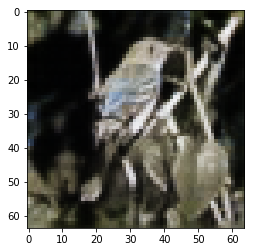

In [101]:
plt.imshow(a[8].squeeze())

##### Autoencoder with Deconvolutions trained with Mean Squared Error Loss

In [85]:
model = Autoencoder_conv() # without batch normalization
model.to('cuda')
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
train(model)

training loss in epoch 0 is :  0.021100125281887802
test loss in epoch 0 is :  0.1001118036866602
training loss in epoch 1 is :  0.013148465561268686
test loss in epoch 1 is :  0.06570554260785381
training loss in epoch 2 is :  0.011500362927714983
test loss in epoch 2 is :  0.05767248462264737
training loss in epoch 3 is :  0.010460357846958297
test loss in epoch 3 is :  0.052808892007710204
training loss in epoch 4 is :  0.009869780667050153
test loss in epoch 4 is :  0.04983081951892624
training loss in epoch 5 is :  0.009413317343232785
test loss in epoch 5 is :  0.04760075773164216
training loss in epoch 6 is :  0.009103592225432802
test loss in epoch 6 is :  0.04604751355428663
training loss in epoch 7 is :  0.008939517167757968
test loss in epoch 7 is :  0.04527271460069136
training loss in epoch 8 is :  0.00867081382533624
test loss in epoch 8 is :  0.043768535510429904
training loss in epoch 9 is :  0.008540050886875513
test loss in epoch 9 is :  0.04324670113985323
training l

test loss in epoch 81 is :  0.030790656416987378
training loss in epoch 82 is :  0.0060171812969152215
test loss in epoch 82 is :  0.030912796462265153
training loss in epoch 83 is :  0.005974736485985063
test loss in epoch 83 is :  0.030783401957402628
training loss in epoch 84 is :  0.0059611813171582964
test loss in epoch 84 is :  0.0304910207244878
training loss in epoch 85 is :  0.005982155651867795
test loss in epoch 85 is :  0.03056541583242102
training loss in epoch 86 is :  0.005978476525392054
test loss in epoch 86 is :  0.03046967103404717
training loss in epoch 87 is :  0.005962053880881087
test loss in epoch 87 is :  0.030487179251698155
training loss in epoch 88 is :  0.005957815938686229
test loss in epoch 88 is :  0.030422857057096228
training loss in epoch 89 is :  0.005945436935238287
test loss in epoch 89 is :  0.030359935002504952
training loss in epoch 90 is :  0.005943001399995113
test loss in epoch 90 is :  0.03066679954321848
training loss in epoch 91 is :  0.00

training loss in epoch 161 is :  0.005385175455032158
test loss in epoch 161 is :  0.028083695150497887
training loss in epoch 162 is :  0.005383570098831337
test loss in epoch 162 is :  0.027971500634319253
training loss in epoch 163 is :  0.00533867485783234
test loss in epoch 163 is :  0.02785560920731061
training loss in epoch 164 is :  0.005357675230586711
test loss in epoch 164 is :  0.02792691336556648
training loss in epoch 165 is :  0.005379836407623121
test loss in epoch 165 is :  0.028016741904947493
training loss in epoch 166 is :  0.0053688221433687774
test loss in epoch 166 is :  0.0279744158550683
training loss in epoch 167 is :  0.005339955247393778
test loss in epoch 167 is :  0.027856180308541905
training loss in epoch 168 is :  0.0053628464625375405
test loss in epoch 168 is :  0.027890375058632344
training loss in epoch 169 is :  0.0053516166335364585
test loss in epoch 169 is :  0.02784524980880734
training loss in epoch 170 is :  0.005356776721294032
test loss in 

Preliminary results at the 200th iteration:

training loss in epoch 200 is :  0.0051837045838739595

test loss in epoch 200 is :  0.027217612679426868

In [ ]:
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())

a = out.detach().cpu().numpy()

a = np.transpose(a,(0,2,3,1))

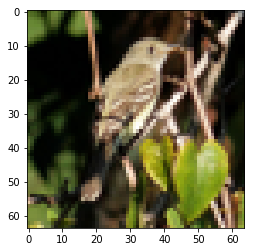

In [100]:
plt.imshow(np.transpose(dataset.test_images[8],(1,2,0)))

Visualization of the preliminary results by rendering one of the colorized test images. There is not much improvement in the colorization - i.e. changing the loss function has not yielded substatial changes in the conduct of the model - i.e. other approaches should be tried.

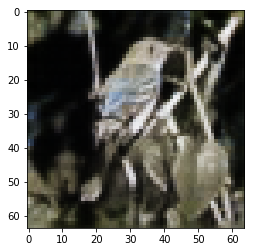

In [98]:
plt.imshow(a[8].squeeze())

##### Autoencoder with Nearest neighbors Upsampling

In [ ]:
model = Autoencoder_near()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
model.to('cuda')
train(model)

In [10]:
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)


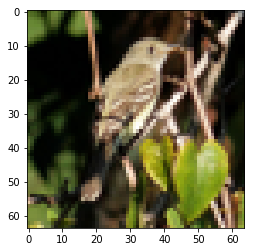

In [11]:
plt.imshow(np.transpose(dataset.test_images[8],(1,2,0)))

This is the worst up until now - it has not even learned to repeat the birds features and reconstucts a blurry nothingness. The explanation for this could be the insufficiency of depth of the model, as the model is more shallow than the original ' Let there be Color" architecture

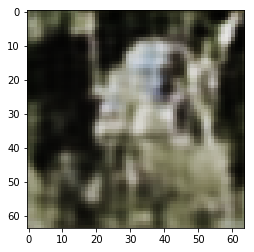

In [12]:
plt.imshow(a[8].squeeze()) # :(

#### Autoencoder with Deconvolutions (shallow) trained with Binary Cross Entropy Loss & the later added Dropout with probability 0.5

In [12]:
model = Autoencoder_conv()
init_weights(model.conv1)
init_weights(model.conv2)
init_weights(model.conv3)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
model.to('cuda')
train(model)

training loss in epoch 0 is :  0.6094296886807397
test loss in epoch 0 is :  3.1101080601414046
training loss in epoch 1 is :  0.5952986227411802
test loss in epoch 1 is :  3.0470803984337382
training loss in epoch 2 is :  0.5928746571346205
test loss in epoch 2 is :  3.03532848176029
training loss in epoch 3 is :  0.591498796226216
test loss in epoch 3 is :  3.0296232228477797
training loss in epoch 4 is :  0.5906361317148014
test loss in epoch 4 is :  3.023913335469034
training loss in epoch 5 is :  0.5899980583158481
test loss in epoch 5 is :  3.021618939108319
training loss in epoch 6 is :  0.5895073125962498
test loss in epoch 6 is :  3.0186959645814366
training loss in epoch 7 is :  0.5895001997753065
test loss in epoch 7 is :  3.0207144949171276
training loss in epoch 8 is :  0.5887613478971987
test loss in epoch 8 is :  3.0153411651651063
training loss in epoch 9 is :  0.5888678123350857
test loss in epoch 9 is :  3.0161726160181894
training loss in epoch 10 is :  0.58841929954

training loss in epoch 85 is :  0.5846288151481525
test loss in epoch 85 is :  2.98746278633674
training loss in epoch 86 is :  0.584927648103156
test loss in epoch 86 is :  2.9886746580402055
training loss in epoch 87 is :  0.5844947225382539
test loss in epoch 87 is :  2.9875866514113216
training loss in epoch 88 is :  0.5846829990140435
test loss in epoch 88 is :  2.987489253282547
training loss in epoch 89 is :  0.584439890725272
test loss in epoch 89 is :  2.9862609886460834
training loss in epoch 90 is :  0.5843480614577832
test loss in epoch 90 is :  2.9866218061910734
training loss in epoch 91 is :  0.5843026041984558
test loss in epoch 91 is :  2.9856471137868033
training loss in epoch 92 is :  0.5845491217107189
test loss in epoch 92 is :  2.987342744237847
training loss in epoch 93 is :  0.5844915051038574
test loss in epoch 93 is :  2.987146276566717
training loss in epoch 94 is :  0.5843584861885123
test loss in epoch 94 is :  2.985660415556696
training loss in epoch 95 is

training loss in epoch 168 is :  0.583612880739225
test loss in epoch 168 is :  2.980097425480684
training loss in epoch 169 is :  0.5836126212360097
test loss in epoch 169 is :  2.980139277047581
training loss in epoch 170 is :  0.5835707702604281
test loss in epoch 170 is :  2.979829212029775
training loss in epoch 171 is :  0.583470665678686
test loss in epoch 171 is :  2.9794788931806884
training loss in epoch 172 is :  0.5834614958892874
test loss in epoch 172 is :  2.9791284418768353
training loss in epoch 173 is :  0.5835762173951078
test loss in epoch 173 is :  2.9797369870874615
training loss in epoch 174 is :  0.5836961914081963
test loss in epoch 174 is :  2.9809320684936313
training loss in epoch 175 is :  0.5834505732367639
test loss in epoch 175 is :  2.9793265561262765
training loss in epoch 176 is :  0.5835061908579197
test loss in epoch 176 is :  2.9798155369030104
training loss in epoch 177 is :  0.5834124493761127
test loss in epoch 177 is :  2.979932334687975
traini

Preliminary results at the 200th iteration:

training loss in epoch 200 is :  0.5834557693831774

test loss in epoch 200 is :  2.9791515924864345

In [13]:
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)

b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


### Dropout with 0.5 probability

Visualization of the preliminary results by rendering one of the colorized test images. The preliminary results 
show an improvement in the generalization as the overfitting is less. However not we observe that even the train set images are not well colorize - so maybe the dropout probability should be decreased.

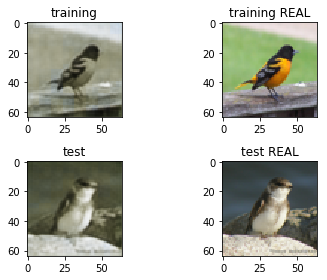

In [33]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[0].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[0],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[1],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

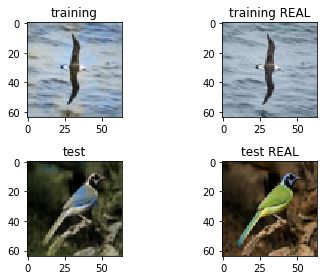

In [25]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[6].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[6],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

## Testing models trained on the servers

### Autoencoder with Deconvolutions (shallow) trained with BCE Loss without Dropout 400 Epochs

In [12]:
model.load_state_dict(torch.load('model400'))

In [14]:
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

(10, 64, 64, 3)


In [15]:
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)


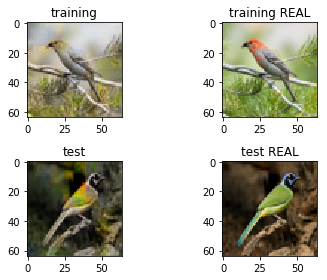

In [19]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

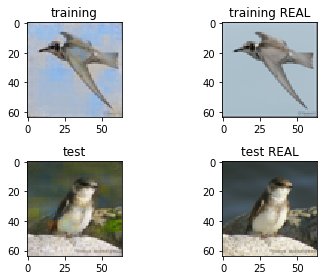

In [20]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[1],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

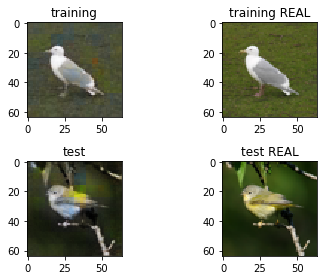

In [22]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[-1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[-1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with BCE Loss without Dropout 1000 Epochs

In [14]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_auto1000'))

In [15]:
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

(10, 64, 64, 3)


In [16]:
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)


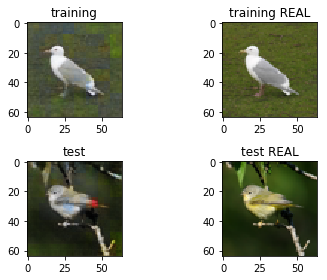

In [17]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[-1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[-1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

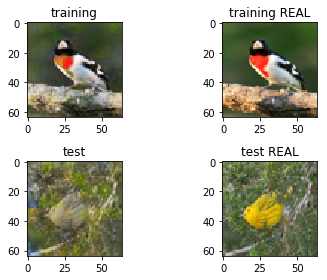

In [20]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[5].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[5],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[5].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[5],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

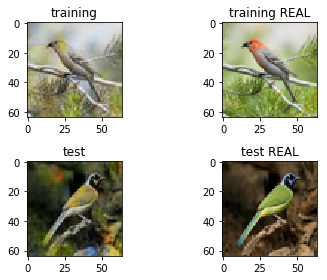

In [19]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 1000 Epochs

In [ ]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_MSE_auto1000'))
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

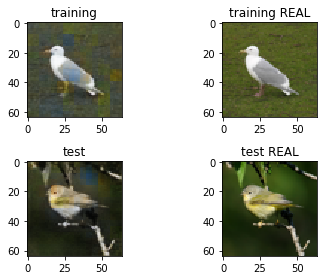

In [22]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[-1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[-1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

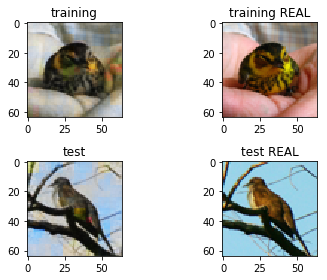

In [25]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[6].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[6],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[6].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[6],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

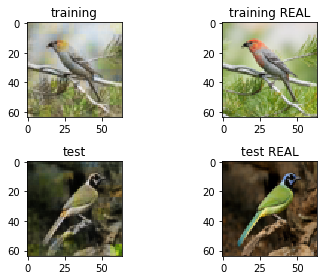

In [24]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with BCE Loss without Dropout 1000 Epochs

In [14]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_auto1500'))
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(30, 64, 64, 3)
(30, 64, 64, 3)


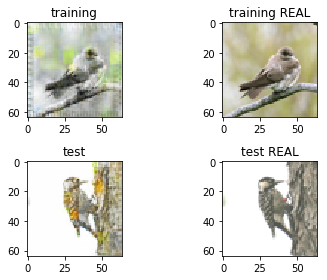

In [16]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[29].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[29],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

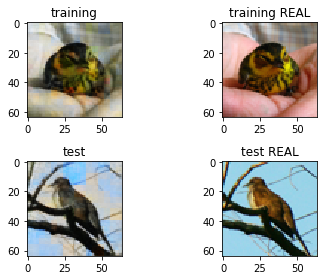

In [25]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[6].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[6],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[6].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[6],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

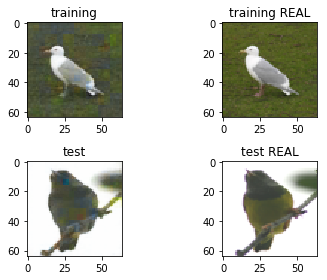

In [29]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[-1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 1500 Epochs

In [18]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_MSE_auto1500'))
out = model.forward(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


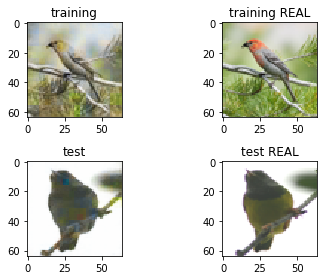

In [30]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

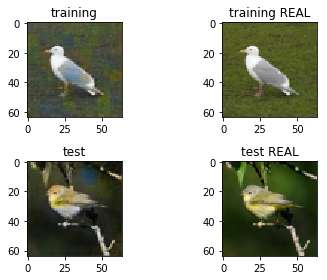

In [20]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[-1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[-1].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

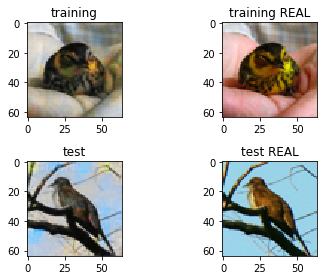

In [21]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[6].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[6],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[6].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[6],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

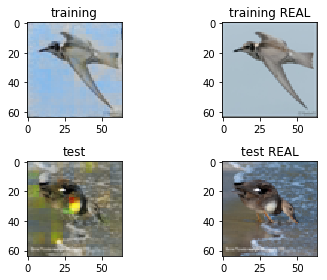

In [23]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[3].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[3],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

Preliminary conclusions: no substantial differences are observed when training the models with BCE or MSE. However we notice that adding Batch normalization has improved the colorization results. A problem is however that increasing the number of epochs does not seem to improve the quality of he colorization : on the contrary it seems to make it worse. 

#### Test with a smaller batch size 

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 200 Epochs Batch size 32

In [9]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_auto200_32'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


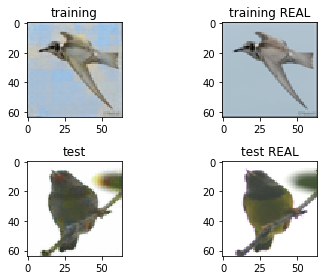

In [16]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

In [8]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a400_32'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


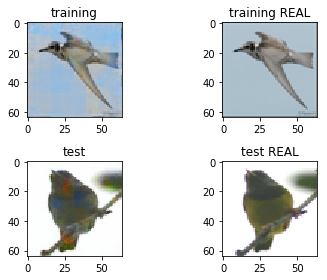

In [9]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

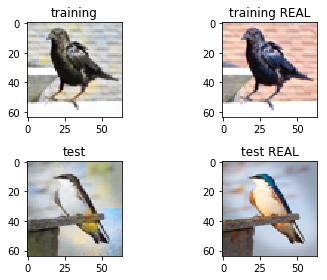

In [11]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[2].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[2],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[2].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[2],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 800 Epochs Batch size 32 & Larger dataset

In [12]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a800_32'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


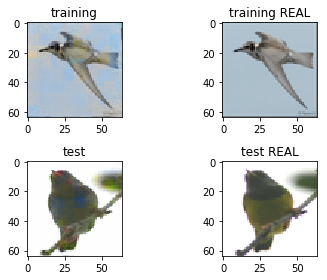

In [13]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

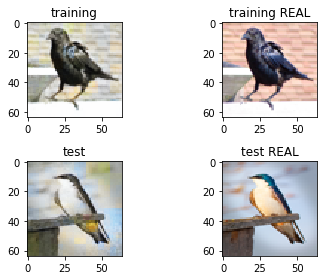

In [14]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[2].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[2],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[2].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[2],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

#### Try adding more data to the training set by transfering images from the test to the training set

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 200 Epochs Batch size 32 & Larger training dataset

In [23]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a200_32mi'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


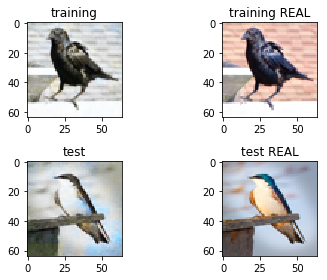

In [24]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[2].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[2],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[2].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[2],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

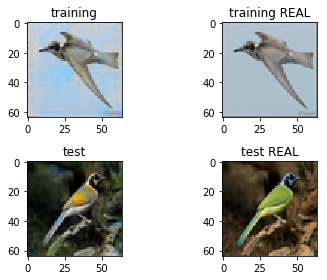

In [27]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 1000 Epochs Batch size 64 & Larger training dataset

In [32]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a1000_64mi'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


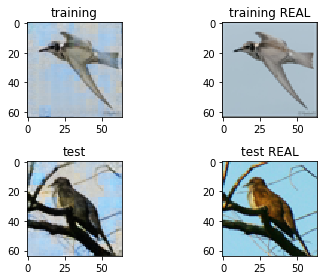

In [36]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[6].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[6],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

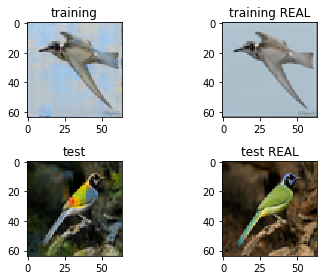

In [37]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[1].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[1],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

As we see the shallow model is improved after adding more images to the training set. However the different batch sizes do not seem to lead to an imporval of performance. We will try adding dropout. 

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss without Dropout 500 Epochs Batch size 64 & Larger training dataset

In [97]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a500_64dropout'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


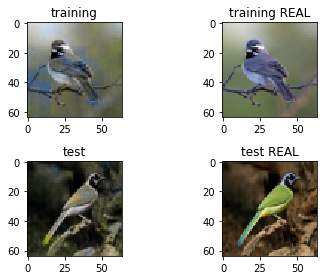

In [99]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[7].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[7],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (shallow) trained with MSE Loss with Dropout 1000 Epochs Batch size 64 & Larger training dataset

In [94]:
model = Autoencoder_conv()
model.cuda()
model.load_state_dict(torch.load('model_BCE_a800_64dropout'))
model.eval()
out = model.forward(torch.Tensor(np.mean(dataset.test_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(np.mean(dataset.train_images[:10],axis = 1)[:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


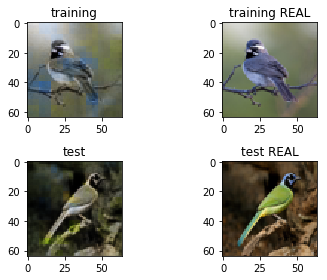

In [96]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[7].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[7],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[8].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[8],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

As expected the dropout leads to less overfitting which means that the most popular colors from the training set do not dominate the test set. However we see that the colors generated, although pleasing to the eye are mostly undefined- something between green and brown. That is why we will try the deeper model

### Autoencoder with Deconvolutions (Deep) trained with MSE Loss without Dropout 200 Epochs Batch size 64 & Larger training dataset

In [10]:
model = Autoencoder_conv_dropout()
model.cuda()
model.load_state_dict(torch.load('model_BCE_200_drop'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


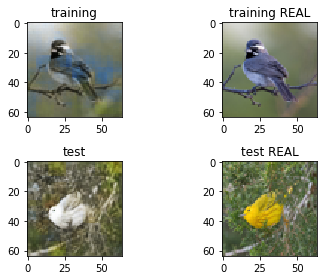

In [14]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[7].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[7],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[5].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[5],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (Deep) trained with MSE Loss without Dropout 500 Epochs Batch size 64 & Larger training dataset

In [15]:
model = Autoencoder_conv_dropout()
model.cuda()
model.load_state_dict(torch.load('model_BCE_500_drop'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


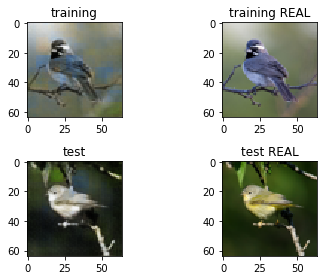

In [23]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[7].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[7],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Autoencoder with Deconvolutions (Deep) trained with MSE Loss without Dropout 700 Epochs Batch size 64 & Larger training dataset

In [120]:
model = Autoencoder_conv_dropout()
model.cuda()
model.load_state_dict(torch.load('model_BCE_700_drop'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


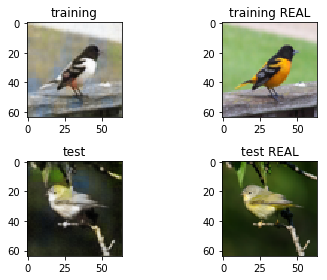

In [122]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[0].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[0],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

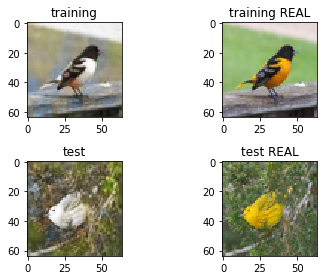

In [124]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[0].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[0],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[5].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[5],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

Here we see the most eye pleasing results. Thus this will be the benchmark on which we will compare the results yielded by the text_to_color colorizer

### Autoencoder with Nearest neighbors Interpolation as Upsampling approach (let there be color)

In [118]:
model = Autoencoder_near_copy()
model.cuda()
model.load_state_dict(torch.load('model_BCE_200_copy'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


/home/ek/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


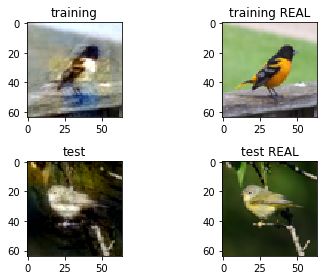

In [119]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[0].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[0],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

In [125]:
model = Autoencoder_near_copy()
model.cuda()
model.load_state_dict(torch.load('model_BCE_500_copy'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


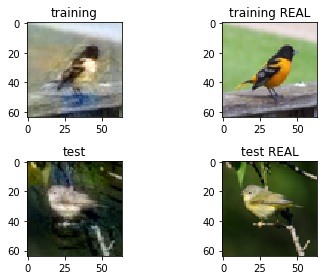

In [126]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[0].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[0],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

## TESTING with FLOWERS

### Autoencoder with Deconvolutions (Deep) trained with MSE Loss without Dropout 300 Epochs Batch size 64 

In [11]:
model = Autoencoder_conv_dropout()
model.cuda()
model.load_state_dict(torch.load('model_flowers300'))
model.eval()
out = model.forward(torch.Tensor(dataset.test_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)
out = model.forward(torch.Tensor(dataset.train_images[:10,0,:,:][:,None,:,:]).cuda(),train=False)
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)


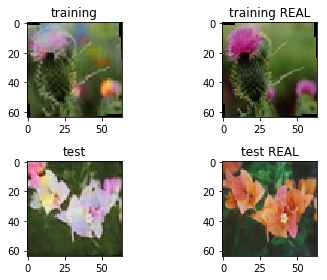

In [12]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[9].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[9],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[0].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[0],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

The results on the flowers dataset are also pleasing to the eye, although not perfect, but they are ok for the benchmark